# Winter 2026 COMP 579 Assignment 2 Starter Code

In this assignment, you will experiment with different algorithms to evaluate a given fixed policy.

Following the instructions in the questions document, fill in the missing code indicated by "TODO" marks.

In [7]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import gymnasium as gym
from collections import defaultdict
from typing import Dict, Tuple, List

## Question 1

Do NOT change the RANDOM_SEED value set in the next code cell. This ensures reproducibility.

In [8]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

We will start by initialising our environment:

> Before you proceed, we recommend that you check the Gymnasium Documentation: https://gymnasium.farama.org/ and play around with the Frozen Lake environment https://gymnasium.farama.org/environments/toy_text/frozen_lake/ to get more comfortable with Gym, as you will be frequently using it in RL and the next assignment.





In [9]:
env = gym.make("FrozenLake-v1", is_slippery=True)
env.reset(seed=RANDOM_SEED)

(0, {'prob': 1})

In [10]:
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

states = list(range(number_of_states))
actions = list(range(number_of_actions))

print("States:", number_of_states)
print("Actions:", number_of_actions)

States: 16
Actions: 4


In Frozen Lake, the action space is defined as:

```
0: Move left
1: Move down
2: Move right
3: Move up
```




In [11]:
P = env.unwrapped.P

`P` gives the transition information for the Markov Decision Process (MDP). In Gym’s tabular environments (like FrozenLake), `P` is a dictionary of dictionaries of lists

In [12]:
P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:



`P[state][action]` is a list of possible outcomes when taking "action" in a particular "state", because taking an action in a stochastic environment can lead to multiple next states with different probabilities.
Each element in this list is a tuple of the form:
`(transition probability, next state, reward, is the next next a terminal state?)`


In [8]:
P[0][1]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False),
 (0.3333333333333333, 1, 0.0, False)]

So `P[0][1]` shows all possible outcomes of taking action 1 in state 0, including how likely each outcome is, the resulting state, the reward, and whether the episode ends.

We can visualize our grid by checking the "desc" attribute

In [9]:
env.unwrapped.desc

array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

```
“S” for Start tile
“G” for Goal tile
“F” for frozen tile
“H” for a tile with a hole
```




### Configs

In [13]:
GAMMA = 0.9
CONVERGENCE_THRESHOLD = 1e-8

### Implementing the Policy

In [14]:
def get_terminal_states(P):
    terminal_states = set()

    for s in P:
        # if s == 15:
        #     break
        actions = P[s]
        for a in actions:
            next_states = P[s][a]
            
            all_done_flags_true = True
            for ns in next_states:
                done = ns[3]
                if not done:
                    all_done_flags_true = False
                    
            if all_done_flags_true:
                terminal_states.add(s)

    return terminal_states

In [15]:
terminal_states = get_terminal_states(P)
terminal_states

{5, 7, 11, 12, 15}

In [13]:
desc = env.unwrapped.desc
print(desc)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [14]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [15]:
def get_valid_actions(env, s):
  """
  Given an env and a state, return a list of valid actions at this state.
  An action is valid if it leads to a different state with non-zero probability
  """
  valid_actions = []
  for a in range(env.action_space.n):
      for (prob, next_s, _, _) in P[s][a]:
          if prob > 0 and next_s != s:
              valid_actions.append(a)
              break
  return valid_actions

In [16]:
def right_favoring_policy(env, s):
    pi = np.zeros(number_of_actions)

    # skip terminal states
    if s in terminal_states:
        return pi

    valid_actions = get_valid_actions(env, s)

    if len(valid_actions) == 1:
        pi[valid_actions[0]] = 1
        return pi

    if RIGHT in valid_actions:
        pi[RIGHT] = 0.7
        other_prob = (1 - 0.7) / (len(valid_actions) - 1)
    else:
        other_prob = 1 / len(valid_actions)

    # set the probability for the rest of the actions
    for a in valid_actions:
        if a == RIGHT:
            continue
        pi[a] = other_prob

    return pi


### Deriving $v_\pi$ with Matrix Inversion

In [17]:
def policy_evaluation_analytical(env, policy, gamma):

    r_pi = np.zeros(number_of_states)
    P_pi = np.zeros((number_of_states, number_of_states))

    # build r_pi and P_pi
    for s in states:
        pi_s = policy(env, s)  # (0.7, 0.1, 0.1, 0.1)

        for a in get_valid_actions(env, s):
            pi_a = pi_s[a]  # 0.7

            for ns in P[s][a]:  # (prob, next_s, reward, done)
                prob = ns[0]
                next_s = ns[1]
                r = ns[2]
                r_pi[s] += prob * r * pi_a
                P_pi[s, next_s] += pi_a * prob

    I = np.eye(number_of_states)

    V = np.linalg.inv(I - gamma * P_pi) @ r_pi

    return V

In [18]:
V_analytical = policy_evaluation_analytical(env, right_favoring_policy, gamma=GAMMA)
V_analytical

array([0.00917343, 0.00857936, 0.02013823, 0.00394009, 0.01316506,
       0.        , 0.04764794, 0.        , 0.0351977 , 0.10546422,
       0.15633561, 0.        , 0.        , 0.22254004, 0.49621811,
       0.        ])

### Synchronous DP

In [19]:
def synchronous_policy_evaluation(P, policy, gamma, tol):
    V = np.zeros(number_of_states)
    residuals = []
    residual = np.inf

    while not residual < tol:
        residual = 0
        V_new = np.zeros(number_of_states)

        for s in states:
            v = V[s]

            pi_s = policy(env, s)
            for a in get_valid_actions(env, s):
                pi_a = pi_s[a]

                q = 0
                for prob, next_s, reward, done in P[s][a]:
                    q += prob * (reward + gamma * V[next_s])

                V_new[s] += pi_a * q

            diff = abs(v - V_new[s])
            residual = max(residual, diff)

        V = V_new
        residuals.append(residual)

    return V, residuals

In [20]:
V_sync, residuals = synchronous_policy_evaluation(P, right_favoring_policy, GAMMA, CONVERGENCE_THRESHOLD)

In [21]:
V_sync

array([0.00917341, 0.00857935, 0.02013822, 0.00394008, 0.01316505,
       0.        , 0.04764793, 0.        , 0.03519769, 0.10546421,
       0.15633561, 0.        , 0.        , 0.22254003, 0.4962181 ,
       0.        ])

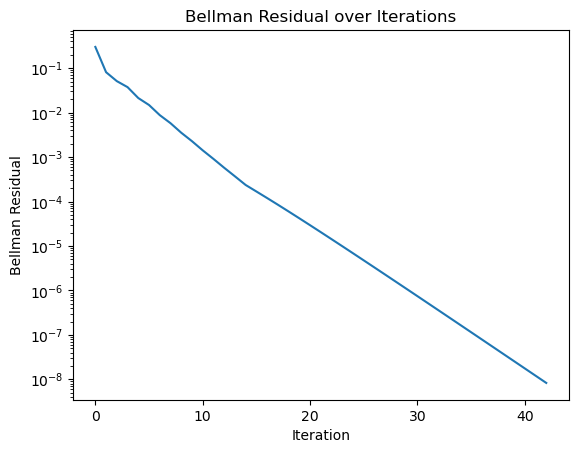

In [22]:
plt.figure()
plt.plot(residuals)
plt.yscale("log")
plt.title("Bellman Residual over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Bellman Residual")
plt.show()

The residual becomes less than $10^{-3}$ and the algorithm stops at aound 42th iteraton. Since the y-axis is in log scale, the residual decreases at an exponential rate across iterations. The rate slows down as it converges to 0. 

### Value Function Visualization

In [23]:
def plot_value_heatmap(env, V, title):
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    V_grid = V.reshape(nrow, ncol)

    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(V_grid, cmap="YlGnBu")

    # annotate each cell with value + tile type
    for r in range(nrow):
        for c in range(ncol):
            text = str(round(V_grid[r, c], 5)) + "\n" + desc[r, c]
            ax.text(c, r, text, ha="center", va="center", color="black", fontsize=10)

    ax.set_title(title)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    ax.set_xticks(range(ncol))
    ax.set_yticks(range(nrow))

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

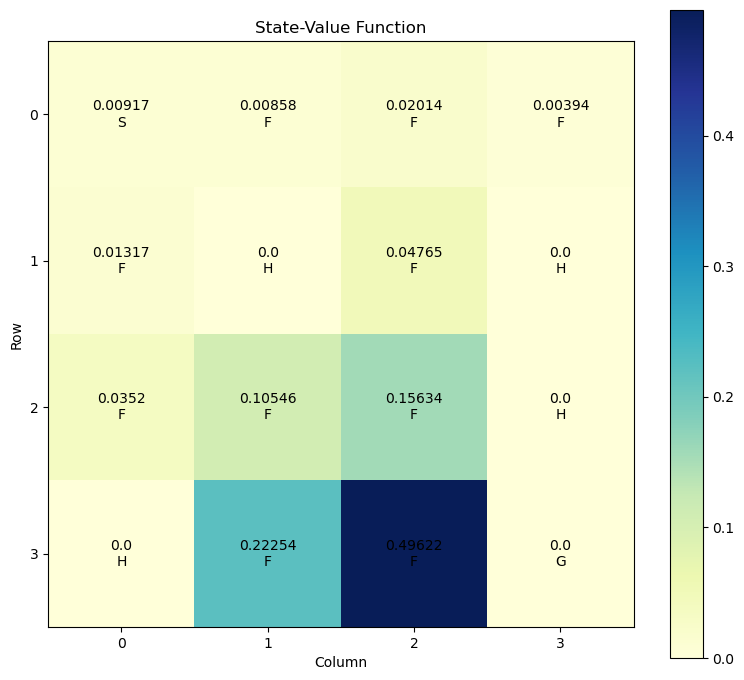

In [24]:
plot_value_heatmap(env, V_sync, title="State-Value Function")

For states except the holes, the closer to the goal state, the higher the state value is. For the states that are far away from the goal state, their state values are significantly lower due to the discounted return. The state 14 has the highest state value because it has the highest probability of reaching the goal state soon.

The state values for the hole tiles are 0 since whenever the player moves into a hole, the episode will terminate and the player will never reach the goal state.

### Non-stationary

In [25]:
def uniform_random_policy(env, s):
    pi = np.zeros(number_of_actions)  # action-probability vector at state s

    if s in terminal_states:
        return pi
    
    valid_actions = get_valid_actions(env, s)

    for a in valid_actions:
        pi[a] = 1 / len(valid_actions)

    return pi

In [26]:
def non_stationary_policy_evaluation(P, policy_A, policy_B, gamma, total_steps, switch_interval):
    V = np.zeros(number_of_states)
    residuals = []
    V_norms = []

    switch_counter = 0
    for t in range(0, total_steps):
        # switch policy every 4 steps
        if switch_counter < switch_interval:
            current_policy = policy_A
        elif switch_counter < (2 * switch_interval):
            current_policy = policy_B 
        else:
            current_policy = policy_A
            # reset counter
            switch_counter = 0

        residual = 0
        V_new = np.zeros(number_of_states)

        for s in states:
            v = V[s]

            pi_s = current_policy(env, s)
            for a in get_valid_actions(env, s):
                pi_a = pi_s[a]
                q = 0

                for prob, next_s, reward, done in P[s][a]:
                    q += prob * (reward + gamma * V[next_s])

                V_new[s] += pi_a * q

            diff = abs(v - V_new[s])
            residual = max(residual, diff)

        V = V_new
        residuals.append(residual)

        switch_counter += 1

    return V, residuals, V_norms

In [27]:
non_stationary_V, non_stationary_residuals, non_stationary_V_norms = non_stationary_policy_evaluation(P, right_favoring_policy, uniform_random_policy, GAMMA, 40, 4)

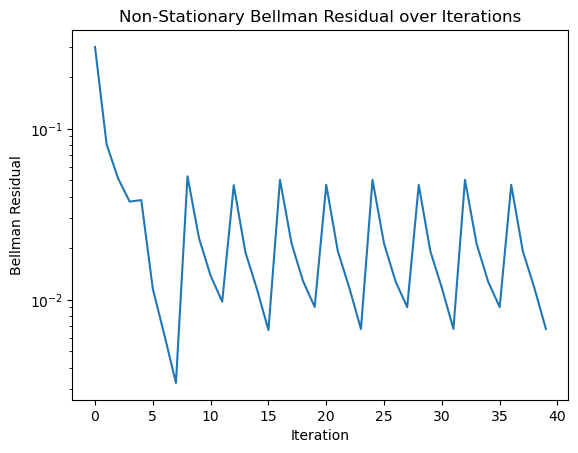

In [28]:
plt.figure()
plt.plot(non_stationary_residuals)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Bellman Residual")
plt.title("Non-Stationary Bellman Residual over Iterations")
plt.show()

For non-stationary scenerios, the residue is high initially and drops sharply for early iterations. However, instead of converging to zero as in the stationary scenerio, the residue shows a repeating oscillatory pattern and keeps oscillating between approximately 0.007 to 0.05. The residue rises whenever the policy switches and gradually drops over the next 4 iteration, but rise again as the policy switches again.


## Question 2

### 2D Random Walk Environment

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
from itertools import zip_longest

In [17]:
class RandomWalk2DEnv:

    def __init__(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
        self.reset()

    def reset(self):
        self.state = np.array([0.5, 0.5])
        return self.state.copy()

    def sample_action(self):
        return np.array([
            random.uniform(-0.2, 0.2),
            random.uniform(-0.2, 0.2)
        ])

    def step(self, action):
        next_state = self.state + action

        # Check termination
        done = (
            next_state[0] < 0 or next_state[0] > 1 or
            next_state[1] < 0 or next_state[1] > 1
        )

        # Reward function
        reward = next_state[0] + next_state[1] if done else 0.0

        self.state = next_state
        return next_state.copy(), reward, done


### Tile coding software (from incompleteideas.net)

In [18]:
basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        return (
            "Collision table:"
            + " size:" + str(self.size)
            + " overfullCount:" + str(self.overfullCount)
            + " dictionary:" + str(len(self.dictionary)) + " items"
        )

    def count(self):
        return len(self.dictionary)

    def fullp(self):
        return len(self.dictionary) >= self.size

    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount == 0:
                print("IHT full, starting to allow collisions")
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m) == IHT:
        return m.getindex(tuple(coordinates), readonly)
    if type(m) == int:
        return basehash(tuple(coordinates)) % m
    if m is None:
        return coordinates


def tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    """Returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // numtilings)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


def tileswrap(ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """Returns num-tilings tile indices with wrapping"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b % numtilings) // numtilings
            coords.append(c % width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


### Fixed tiling parameters

In [19]:
NUM_TILINGS = 8
TILES_PER_DIM = 4          # 4 x 4 per tiling
IHT_SIZE = 4096

# Global index hash table
iht = IHT(IHT_SIZE)

In [20]:
def tile_coding_indices(state):

    x, y = state

    return tiles(
        ihtORsize=iht,
        numtilings=NUM_TILINGS,
        floats=[x * TILES_PER_DIM, y * TILES_PER_DIM]
    )

def tile_coding_feature_vector(state):

    phi = np.zeros(IHT_SIZE)
    for idx in tile_coding_indices(state):
        phi[idx] = 1.0
    return phi


### Test

In [21]:
s = (0.5, 0.5)
idx = tile_coding_indices(s)

print("Active tiles:", idx)
print("Number of active tiles:", len(idx))  # should be 8


Active tiles: [0, 1, 2, 3, 4, 5, 6, 7]
Number of active tiles: 8


### Part (a)

Given reward is 0 until termination and the reward is equal to the sum of the coordinates of the terminal state, so $G = R_{t} = X_{t} + Y_{t}$. Therefore the value function is $V(x,y) = \mathbb{E} \{ X_{t} + Y_{t} \mid X_{0} = x, Y_{0} = y \} $.

We know that at each time step, the agent selects a random action according to uniform probability from its action space. For whichever direction the agent might take, there is also a equal probability that the agent could take the opposite direction. Thus, due the symmetry of the random walk, $\mathbb{E} \{ \Delta X_{t} \} = 0 $, and $\mathbb{E} \{ \Delta Y_{t} \} = 0 $.

Given $S_{t+1} = S_{t} + A_{t}$, where $A_{t} = (\Delta X_{t}, \Delta Y_{t})$. At each step, the coordinate of the next state will be $(X_{t+1}, Y_{t+1}) = (X_{t} + \Delta X_{t}, Y_{t} + \Delta Y_{t})$. So, $\mathbb{E}\{ X_{t+1} + Y_{t+1} \} = \mathbb{E} \{ X_{t} + \Delta X_{t} + Y_{t} + \Delta Y_{t} \} = \mathbb{E}\{ X_{t} + Y_{t} \}$. This shows that $X_{t} + Y_{t}$ has no expected change over time. Therefore, $V(x,y) = \mathbb{E} \{ X_{t} + Y_{t} \mid X_{0} = x, Y_{0} = y \} = \mathbb{E} \{ X_{0} + Y_{0} \mid X_{0} = x, Y_{0} = y \} = x + y$


### Part b)

#### Every-visit Monte Carlo Agent

In [22]:
class MCAgentTileCoding:
    def __init__(self, alpha=0.1):
        ## initialize alpha and weights
        self.alpha = alpha
        self.weight = np.zeros(IHT_SIZE)

    def value(self, state):
        ## compute sum of weights for active tiles
        active = tile_coding_indices(state)
        return np.sum(self.weight[active])

    def update_episode(self, episode):
        ## update weights for each state in the episode
        for i in range(0, len(episode)):
            G = 0

            for j in range(i, len(episode)):    # for cur and all following states in the episode
                s_r = episode[j]
                r = s_r[1]
                G += r

            s_r = episode[i]
            s = s_r[0]
            V = self.value(s)

            for idx in tile_coding_indices(s):
                self.weight[idx] += self.alpha * (G - V)

#### Run MC experiments

In [23]:
def run_mc_experiment(
    learning_rates=[0.1, 0.03, 0.01, 0.003, 0.001], 
    num_episodes=1000, 
    num_runs=30
):
    """
    Run every-visit Monte Carlo prediction experiments using Tile Coding.
    Returns mean and std of MSVE for each learning rate.
    """
    mean_msve = {}  # placeholder
    std_msve = {}  # placeholder

    for alpha in learning_rates:
        msve_runs = []

        for run in range(0, num_runs):
            env = RandomWalk2DEnv(run)
            agent = MCAgentTileCoding(alpha)

            for ep in range(num_episodes):
                state = env.reset()
                done = False
                episode = []

                while not done:
                    action = env.sample_action()
                    next_state, reward, done = env.step(action)

                    episode.append((state.copy(), reward))
                    state = next_state
                
                agent.update_episode(episode)

            msve = compute_msve(agent)
            msve_runs.append(msve)

        mean_msve[alpha] = np.mean(msve_runs)
        std_msve[alpha] = np.std(msve_runs)

    return mean_msve, std_msve

#### MSVE Evaluation

In [24]:
def compute_msve(agent):
    """
    Compute the Mean Squared Value Error (MSVE) over a 21x21 grid
    in [0,1] x [0,1] using the true value function V(x, y) = x + y.
    """
    msve = 0.0  # placeholder

    xs = np.linspace(0, 1, 21)
    ys = np.linspace(0, 1, 21)

    sve = 0
    n = 0

    for x in xs:
        for y in ys:
            s = np.array([x, y])
            true = x + y
            pred = agent.value(s)
            sve += (pred - true) ** 2
            n += 1

    msve = sve / n
    return msve

#### Main execution

Mean MSVE ± Std Dev over 30 runs after 1000 episodes:
α=0.1: 0.16765 ± 0.07292
α=0.03: 0.07890 ± 0.03556
α=0.01: 0.04576 ± 0.01546
α=0.003: 0.05289 ± 0.00566
α=0.001: 0.11034 ± 0.00703


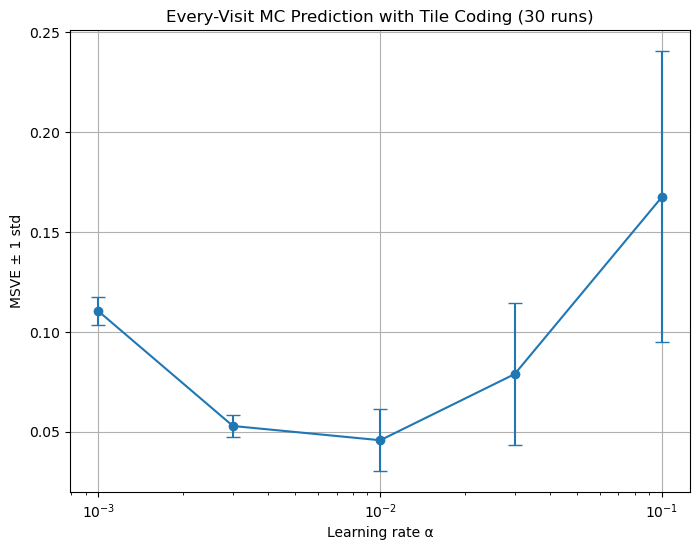

In [38]:
def plot_mc_results(mean_msve, std_msve):
    alphas = list(mean_msve.keys())
    means = np.array(list(mean_msve.values()))
    stds = np.array(list(std_msve.values()))

    plt.figure(figsize=(8,6))
    plt.errorbar(alphas, means, yerr=stds, fmt='o-', capsize=5)
    plt.xscale('log')
    plt.xlabel("Learning rate α")
    plt.ylabel("MSVE ± 1 std")
    plt.title("Every-Visit MC Prediction with Tile Coding (30 runs)")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    learning_rates = [0.1, 0.03, 0.01, 0.003, 0.001]

    mean_msve, std_msve = run_mc_experiment(
        learning_rates=learning_rates,
        num_episodes=1000,
        num_runs=30
    )

    print("Mean MSVE ± Std Dev over 30 runs after 1000 episodes:")
    for alpha in learning_rates:
        print(f"α={alpha}: {mean_msve[alpha]:.5f} ± {std_msve[alpha]:.5f}")

    plot_mc_results(mean_msve, std_msve)


### Part c)

#### TD(λ) Agent (Accumulating Traces)

In [25]:
class TDAgentLambda:
    def __init__(self, alpha=0.01, gamma=1.0, lam=0.5):
        """
        alpha: learning rate
        gamma: discount factor
        lam: trace decay parameter
        """
        ## initialize weights and eligibility traces ##
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        self.weight = np.zeros(IHT_SIZE)
        self.e_traces = np.zeros(IHT_SIZE)

    def value(self, state):
        """
        Return the current value estimate for a given state.
        """
        ## compute value from active tile indices ##
        active = tile_coding_indices(state)
        return np.sum(self.weight[active])

    def reset_traces(self):
        """
        Reset eligibility traces at the start of each episode.
        """
        ## reset eligibility traces ##
        self.e_traces = np.zeros(IHT_SIZE)

    def update(self, state, reward, next_state, done):
        """
        Perform a TD(lambda) update for a single step.
        """
        ## update weights using accumulating traces ##
        active = tile_coding_indices(state)

        V = np.sum(self.weight[active])

        if done:
            V_next = 0
        else:
            V_next = self.value(next_state)

        delta = reward + self.gamma * V_next - V

        # update eligibility traces
        self.e_traces *= self.gamma * self.lam
        for idx in active:
            self.e_traces[idx] += 1

        self.weight += self.alpha * delta * self.e_traces

#### Run TD(λ) Experiments

In [26]:
def run_td_lambda_experiment(
    lambdas=[0, 0.25, 0.5, 0.75, 0.9],
    alphas=[0.001, 0.003, 0.01, 0.03, 0.08],
    num_episodes=1000,
    num_runs=30
):
    results = {}

    # Loop over lambdas and alphas
    # For each seed, initialize env with seed and TDAgentLambda
    # Run num_episodes, update agent each step
    # Compute MSVE over 21x21 grid
    # Average MSVE over runs and store in results

    for lam in lambdas:
        for alpha in alphas:
            msve_runs = []

            for run in range(0, num_runs):
                env = RandomWalk2DEnv(run)

                agent = TDAgentLambda(alpha=alpha, lam=lam)

                for ep in range(num_episodes):
                    state = env.reset()
                    agent.reset_traces()
                    done = False

                    while not done:
                        action = env.sample_action()
                        next_state, reward, done = env.step(action)
                        agent.update(state, reward, next_state, done)
                        state = next_state

                msve_runs.append(compute_msve(agent))
            
            results[(lam, alpha)] = np.mean(msve_runs)
        
    return results

#### Plot 1: MSVE vs α (one curve per λ)

In [41]:
def plot_msve_vs_alpha(results, lambdas, alphas):
    plt.figure(figsize=(8, 6))

    for lam in lambdas:
        msves = [results[(lam, alpha)] for alpha in alphas]
        plt.plot(alphas, msves, marker='o', label=f"λ={lam}")

    plt.xscale("log")
    plt.xlabel("Learning rate α")
    plt.ylabel("Average MSVE")
    plt.title("TD(λ): MSVE vs α")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Plot 2: MSVE vs λ (one curve per α)

In [42]:
def plot_msve_vs_lambda(results, lambdas, alphas):
    plt.figure(figsize=(8, 6))

    for alpha in alphas:
        msves = [results[(lam, alpha)] for lam in lambdas]
        plt.plot(lambdas, msves, marker='o', label=f"α={alpha}")

    plt.xlabel("λ")
    plt.ylabel("Average MSVE")
    plt.title("TD(λ): MSVE vs λ")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Plot 3: Heatmap (λ × α)

In [43]:
import pandas as pd

def plot_heatmap(results):
    df = pd.DataFrame(
        [(lam, alpha, msve) for (lam, alpha), msve in results.items()],
        columns=["lambda", "alpha", "MSVE"]
    )

    heatmap_data = df.pivot(index="lambda", columns="alpha", values="MSVE")

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis")
    plt.xlabel("Learning rate α")
    plt.ylabel("λ")
    plt.title("TD(λ) with Accumulating Traces: MSVE")
    plt.show()


#### Main Execution

Average MSVE over 30 runs after 1000 episodes:
λ=0, α=0.001: MSVE=0.53029
λ=0, α=0.003: MSVE=0.13098
λ=0, α=0.01: MSVE=0.02432
λ=0, α=0.03: MSVE=0.01787
λ=0, α=0.08: MSVE=0.02847
λ=0.25, α=0.001: MSVE=0.41877
λ=0.25, α=0.003: MSVE=0.09124
λ=0.25, α=0.01: MSVE=0.02347
λ=0.25, α=0.03: MSVE=0.01904
λ=0.25, α=0.08: MSVE=0.03110
λ=0.5, α=0.001: MSVE=0.29170
λ=0.5, α=0.003: MSVE=0.06480
λ=0.5, α=0.01: MSVE=0.02356
λ=0.5, α=0.03: MSVE=0.02171
λ=0.5, α=0.08: MSVE=0.03902
λ=0.75, α=0.001: MSVE=0.17184
λ=0.75, α=0.003: MSVE=0.05192
λ=0.75, α=0.01: MSVE=0.02547
λ=0.75, α=0.03: MSVE=0.02901
λ=0.75, α=0.08: MSVE=0.06728
λ=0.9, α=0.001: MSVE=0.12510
λ=0.9, α=0.003: MSVE=0.04941
λ=0.9, α=0.01: MSVE=0.03027
λ=0.9, α=0.03: MSVE=0.04614
λ=0.9, α=0.08: MSVE=0.18741


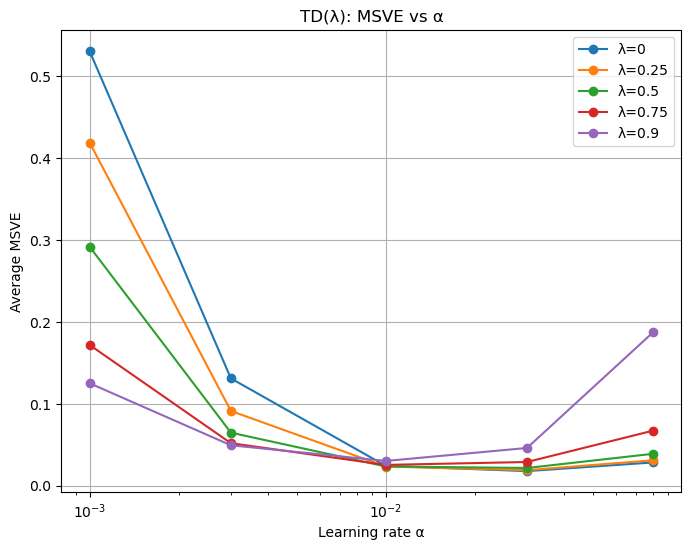

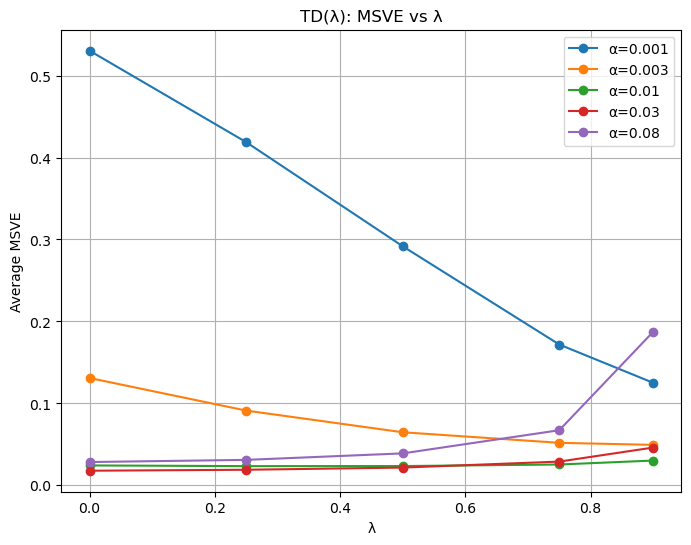

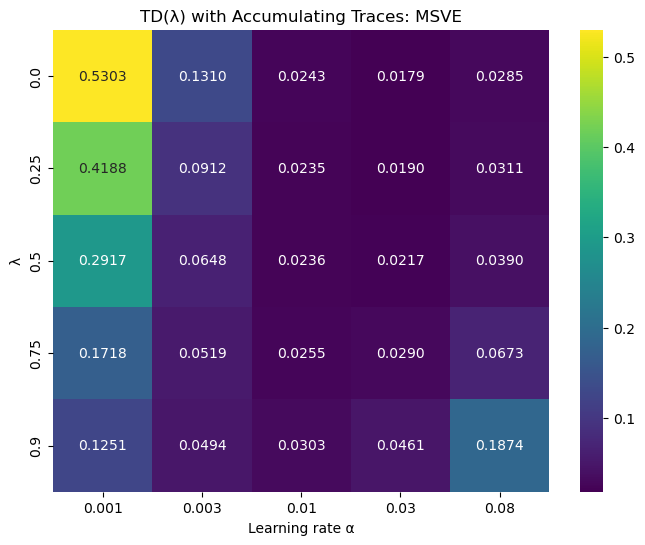

In [44]:
lambdas = [0, 0.25, 0.5, 0.75, 0.9]
alphas = [0.001, 0.003, 0.01, 0.03, 0.08]

results = run_td_lambda_experiment(
    lambdas=lambdas,
    alphas=alphas,
    num_episodes=1000,
    num_runs=30
)

print("Average MSVE over 30 runs after 1000 episodes:")
for (lam, alpha), msve in results.items():
    print(f"λ={lam}, α={alpha}: MSVE={msve:.5f}")

plot_msve_vs_alpha(results, lambdas, alphas)
plot_msve_vs_lambda(results, lambdas, alphas)
plot_heatmap(results)


Explain !!!!!!!!!!!

Compare !!!!!!!!!!!!!

### Part d)

#### TD(0) agent with Tile Coding

In [27]:
class TDAgentTileCoding:
    def __init__(self, alpha=0.1, gamma=1.0):
        ## initialize alpha, gamma, and weights for tile coding
        self.alpha = alpha
        self.gamma = gamma
        self.weight = np.zeros(IHT_SIZE)

    def value(self, state):
        """Estimate value of a state using tile coding."""
        ## return estimated value using active tile indices
        active = tile_coding_indices(state)
        return np.sum(self.weight[active])

    def update(self, state, reward, next_state, done):
        """TD(0) update for a single transition."""
        ## compute TD error and update weights for active tiles
        active = tile_coding_indices(state)
        V = np.sum(self.weight[active])
        if done:
            V_next = 0
        else:
            V_next = self.value(next_state)

        for idx in active:
            self.weight[idx] += self.alpha * (reward + self.gamma * V_next - V)

#### TD(0) agent with 2-layer Neural Network

In [28]:
class NNValueFunction:
    def __init__(self, input_dim=2, hidden_dim=64, alpha=1e-3, gamma=1.0):
        self.alpha = alpha
        self.gamma = gamma
        self.W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, 1) / np.sqrt(hidden_dim)
        self.b2 = np.zeros(1)

    def forward(self, state):
        self.z1 = np.dot(state, self.W1) + self.b1
        self.h1 = np.tanh(self.z1)
        value = np.dot(self.h1, self.W2) + self.b2
        return value.item()

    def td_update(self, state, reward, next_state, done):
        ## compute TD target
        V = self.forward(state)

        if done:
            target = reward
        else:
            target = reward + self.gamma * self.forward(next_state)

        ## compute TD error
        error = target - V

        ## backpropagate TD error through network
        self.forward(state)
        d = -error
        dW2 = self.h1.reshape(-1, 1) * d
        db2 = np.array([d])

        dh1 = (self.W2.flatten()) * d
        dz1 = dh1 * (1 - np.tanh(self.z1) ** 2)

        dW1 = np.outer(state, dz1)
        db1 = dz1

        ## update weights W1, W2 and biases b1, b2 using alpha
        self.W2 -= self.alpha * dW2
        self.b2 -= self.alpha * db2
        self.W1 -= self.alpha * dW1
        self.b1 -= self.alpha * db1


    def value(self, state):
        return self.forward(state)

#### Training

In [29]:
def train_agents(
    alphas=[0.03, 0.01, 0.003, 0.001],
    num_episodes=1000,
    num_runs=30,
):

    tile_msve_mean = {}
    nn_msve_mean = {}

    # ===========================
    # Implement training loop
    # ===========================
    # For each episode:
    # 1. Reset environment
    # 2. For Tile Coding agent:
    #    - Take steps until termination
    #    - Update the tile_agent using TD(0)
    # 3. For Neural Network agent:
    #    - Reset environment again
    #    - Take steps until termination
    #    - Update the nn_agent using td_update
    # 4. Record the value of the center state [0.5, 0.5] for both agents
    for alpha in alphas:
        tile_runs = []
        nn_runs = []

        for run in range(num_runs):
            env_tile = RandomWalk2DEnv(seed=run)
            env_nn = RandomWalk2DEnv(seed=run)

            tile_agent = TDAgentTileCoding(alpha=alpha)
            nn_agent = NNValueFunction(alpha=alpha)

            tile_msve = []
            nn_msve = []

            for ep in range(num_episodes):
                # Tile Coding
                s = env_tile.reset()
                done = False
                while not done:
                    a = env_tile.sample_action()
                    s_next, r, done = env_tile.step(a)
                    tile_agent.update(s, r, s_next, done)
                    s = s_next

                # Neural Network
                s = env_nn.reset()
                done = False
                while not done:
                    a = env_nn.sample_action()
                    s_next, r, done = env_nn.step(a)
                    nn_agent.td_update(s, r, s_next, done)
                    s = s_next

                tile_msve.append(compute_msve(tile_agent))
                nn_msve.append(compute_msve(nn_agent))

            tile_runs.append(tile_msve)
            nn_runs.append(nn_msve)

        tile_msve_mean[alpha] = np.mean(np.array(tile_runs), axis=0)
        nn_msve_mean[alpha] = np.mean(np.array(nn_runs), axis=0)

    return tile_msve_mean, nn_msve_mean

#### Run training and plotting

In [30]:
def plot_nn_tile_msve_vs_alpha(tile_results, nn_results, alphas):
    plt.figure(figsize=(8, 6))

    tile_msves = [tile_results[a][-1] for a in alphas]
    plt.plot(alphas, tile_msves, marker="o", color="tab:blue", label=f"TD(0) trained with tile coding")

    nn_msves = [nn_results[a][-1] for a in alphas]
    plt.plot(alphas, nn_msves, marker="o", color="tab:orange", label=f"TD(0) trained using a neural network")

    plt.xscale("log")
    plt.xlabel("Learning rate α")
    plt.ylabel("Average MSVE")
    plt.title("TD(0): MSVE vs α")
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
def plot_nn_tile_msve_vs_episode(tile_results, nn_results, alphas):
    plt.figure(figsize=(8, 6))

    for alpha, tile_msves in tile_results.items():
        x = np.arange(1, len(tile_msves) + 1)
        plt.plot(x, tile_msves, label=f"Tile coding with α={alpha}")

    for alpha, nn_msves in nn_results.items():
        x = np.arange(1, len(nn_msves) + 1)
        plt.plot(x, nn_msves, linestyle="--", label=f"Neural network with α={alpha}")

    plt.xlabel("Episode")
    plt.ylabel("MSVE")
    plt.title("2D Random Walk: Tile Coding vs Neural Network")
    plt.legend()
    plt.show()

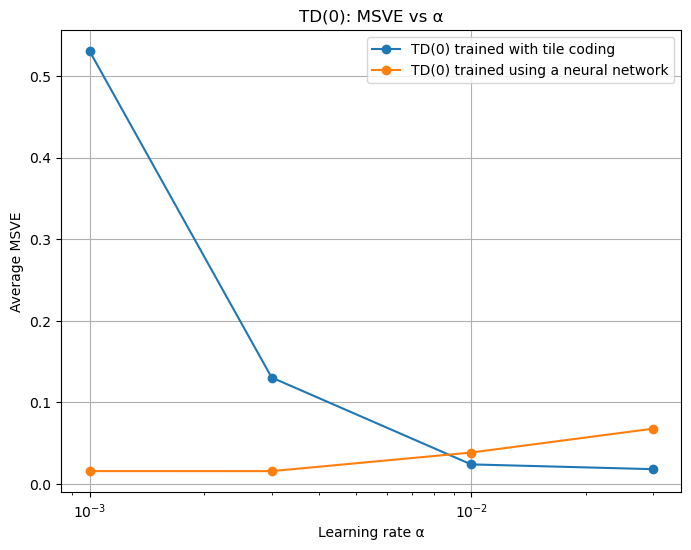

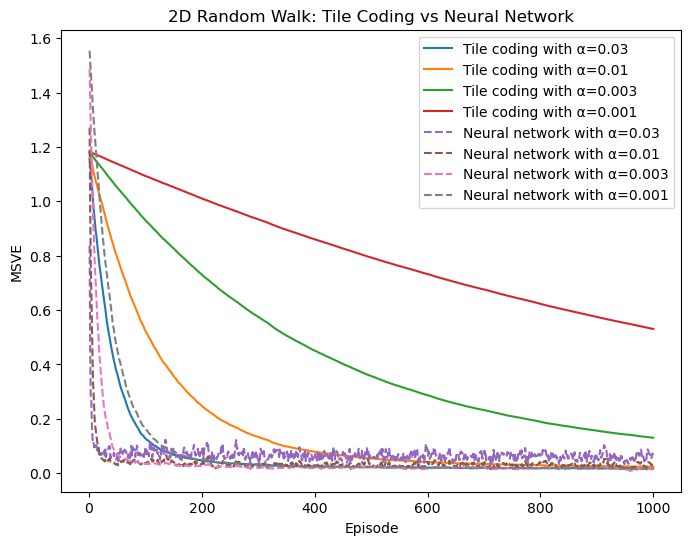

In [32]:
alphas = [0.03, 0.01, 0.003, 0.001]

tile_results, nn_results = train_agents(alphas=alphas, num_episodes=1000, num_runs=30)

plot_nn_tile_msve_vs_alpha(tile_results, nn_results, alphas)
plot_nn_tile_msve_vs_episode(tile_results, nn_results, alphas)

# Question 3

In [ ]:
GAMMA = 0.9
N = 10
r_non_terminal = 0
r_terminal = 1

In [ ]:
def linear_transiton_matrix(N):
  """
  A simple linear transition matrix for N states
  At every state (except the terminal one), the agent deterministically moves
  to s+1. At the terminal state, the agent stays in the terminal state.
  """
  P = np.zeros((N, N))

  for s in range(N-1):
        P[s, s+1] = 1.0

  P[N-1, N-1] = 1.0

  return P

In [ ]:
P = linear_transiton_matrix(N)

In [ ]:
P

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
class LinearChainEnv:
  def __init__(self, N, reward_noise=0):
    self.N = N
    self.terminal = N-1
    self.P = linear_transiton_matrix(N)

    self.reward_noise = reward_noise

    self.reset()

  def reset(self):
    self.state = 0
    return self.state

  def step(self):
    if self.state == self.terminal:
      return self.state, 0.0, True

    next_state_prob = self.P[self.state]
    next_state = np.random.choice(self.N, p=next_state_prob)

    if next_state == self.terminal:
      reward = r_terminal + np.random.randn() * self.reward_noise
    else:
      reward = r_non_terminal + np.random.randn() * self.reward_noise

    self.state = next_state
    done = self.state == self.terminal
    return self.state, reward, done

In [ ]:
class TDAgent:
  """
  Update your implementation from Q2 to work with the new linear chain env
  Hint: Instead of tile coding, use one-hot encoding for the state (every state is a feature)
  """
  def __init__(self, num_states, alpha=0.01, gamma=GAMMA):
    pass

  def value(self, state):
    pass

  def update(self, state, reward, next_state, done):
    pass

In [ ]:
class MCAgent:
  """
  Update your implementation from Q2 to work with the new linear chain env
  Hint: Instead of tile coding, use one-hot encoding for the state (every state is a feature)
  """
  def __init__(self, num_states, alpha=0.01, gamma=GAMMA):
    pass

  def value(self, state):
    pass

  def update_episode(self, episode):
    pass

In [ ]:
def true_value_linear_chain(N, gamma, r_non_terminal=0, r_terminal=1.0):
    V = np.zeros(N)
    #TODO: Implement the true value function
    return V

In [ ]:
V_true = true_value_linear_chain(N, GAMMA, r_non_terminal, r_terminal)

In [ ]:
def compute_msve(agent, V_true):
  # TODO: Implement the MSVE function
  pass

In [ ]:
def train_td0_and_mc(env, V_true, num_episodes=10000, lr=0.003):
  num_states = env.N

  td_agent = TD0Agent(num_states, alpha=lr, gamma=GAMMA)
  mc_agent = MCAgent(num_states, alpha=lr, gamma=GAMMA)

  td_values = []
  mc_values = []
  td_msve = []
  mc_msve = []

  # TODO: Implement the training logic for the two agents

  return td_agent, mc_agent, td_values, mc_values, td_msve, mc_msve

In [ ]:
# TODO: create the two versions of the LinearChainEnv

# TODO: For each env, train your agents and use the below code to plot your values and calculate mean MSVE

# plt.figure()
# plt.plot(td_values, label="TD(0)")
# plt.plot(mc_values, label="MC")
# plt.xlabel("Episode")
# plt.ylabel("V(start state)")
# plt.title("Start state value over episodes")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(td_msve, label="TD(0)")
# plt.plot(mc_msve, label="MC")
# plt.xlabel("Episode")
# plt.ylabel("MSVE")
# plt.title("Mean Squared Value Error over episodes")
# plt.legend()
# plt.show()

# mean_td_msve = sum(td_msve) / len(td_msve)
# mean_mc_msve = sum(mc_msve) / len(mc_msve)

# print("Mean MSVE TD(0):", mean_td_msve)
# print("Mean MSVE MC:", mean_mc_msve)

### **Explain your choice of parameter value and how it affects performance in TD0 and MC:**